# Quantum Sudoku Solver with Qiskit
This notebook demonstrates how to approach solving a simple Sudoku puzzle using quantum computing concepts with Qiskit. We'll use a small 4x4 Sudoku for demonstration, as current quantum hardware and simulators are not yet capable of efficiently solving full 9x9 puzzles.

In [31]:
# Install Qiskit if not already installed (uncomment if needed)
# !pip install qiskit

from qiskit import QuantumCircuit, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeEssexV2
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import numpy as np
import matplotlib.pyplot as plt

## Sudoku 2x2

In [ ]:
# Define a sample 4x4 Sudoku puzzle (0 = empty)
sudoku = np.array([
    [1, 0, 0, 4],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [2, 0, 0, 3]
])

print("Initial 4x4 Sudoku Puzzle:")
print(sudoku)

Initial 4x4 Sudoku Puzzle:
[[1 0 0 4]
 [0 0 0 0]
 [0 0 0 0]
 [2 0 0 3]]


## Quantum Encoding

Each cell can take values 1-4, which can be encoded using 2 qubits per cell (since 2 qubits = 4 states). For a 4x4 Sudoku, we need 16 cells × 2 qubits = 32 qubits. 

# Oracle function
We'll encode the constraints (unique values in rows, columns, and boxes) as quantum logic

In [35]:
## Create constraints

clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]
# Each clause enforces that a number appears only once in a row, column, or box.
# For 4x4 Sudoku, generate clauses for all pairs of cells in the same row, column, or 2x2 box.

# clause_set = set()

# # Row constraints
# for row in range(4):
#     cells_in_row = [4*row + col for col in range(4)]
#     for i in range(4):
#         for j in range(i+1, 4):
#             pair = tuple(sorted((cells_in_row[i], cells_in_row[j])))
#             if pair[0] != pair[1]:
#                 clause_set.add(pair)

# # Column constraints
# for col in range(4):
#     cells_in_col = [4*row + col for row in range(4)]
#     for i in range(4):
#         for j in range(i+1, 4):
#             pair = tuple(sorted((cells_in_col[i], cells_in_col[j])))
#             if pair[0] != pair[1]:
#                 clause_set.add(pair)

# # Box constraints (2x2 boxes)
# for box_row in range(2):
#     for box_col in range(2):
#         cells_in_box = []
#         for i in range(2):
#             for j in range(2):
#                 cells_in_box.append(4*(2*box_row + i) + (2*box_col + j))
#         for i in range(4):
#             for j in range(i+1, 4):
#                 pair = tuple(sorted((cells_in_box[i], cells_in_box[j])))
#                 if pair[0] != pair[1]:
#                     clause_set.add(pair)

# clause_list = list(clause_set)
# print(len(clause_list))

In [38]:
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)


def sudoku_oracle(qc, var_qb, clause_qb, output_qb):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qb[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qb, output_qb)



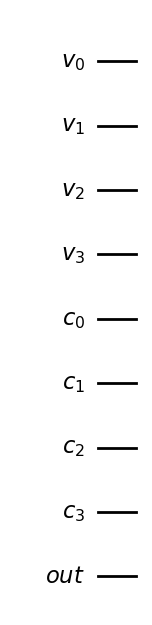

In [40]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(len(clause_list), name='c')
output_qubit = QuantumRegister(1, name='out')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)


qc.draw('mpl')

In [25]:
# create a quantum circuit with 32 qubits (2 per cell)
n_cells = 16
n_qubits = n_cells * 2

# Each cell is represented by 2 qubits: (msb, lsb)
cells = [(2*i, 2*i+1) for i in range(16)]

# Allocate ancillas: 3 for equality checks, 14 for AND tree (ceil(log2(72))=7, but binary tree for 72 inputs needs 71-1=70/2=35, but we use a small number for demo)
anc_eq = [n_qubits + i for i in range(3)]
anc_tree = [n_qubits + 3 + i for i in range(14)]
allgood = n_qubits + 3 + 14
phase = n_qubits + 3 + 14 + 1

total_qubits= phase + 1

qc = QuantumCircuit(total_qubits)

# Initialize all qubits in superposition (all possible assignments)
qc.h(range(n_qubits))

# Prepare phase ancilla in |-> state
qc.h(phase)
qc.z(phase)

# Prepare clues as a dict: {cell_index: value}
clues = {i: int(v) for i, v in np.ndenumerate(sudoku) if v != 0}
clues = {r*4 + c: v for (r, c), v in clues.items()}

# # Call the oracle function
print(anc_eq)
print(anc_tree)
print(allgood)
print(phase)
oracle_4x4_sudoku(qc, cells, anc_eq, anc_tree, allgood, phase, clues)

# Show the circuit
qc.draw('mpl')

[32, 33, 34]
[35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
49
50
marks: [34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34]
34 34 35


CircuitError: 'duplicate qubit arguments'